In [115]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import cgs as cg

In [131]:
def solver(f, x_0, matvec_func):
    x = x_0
    r_0 = f - matvec_func(x_0)
    error_array = []
    
    while(True):
        v = matvec_func(x)
        r = f - v
        error = np.linalg.norm(r)/np.linalg.norm(r_0)
        error_array.append(error)
        if(error < 0.0001):
            break
            
        x = x - v + f  
    
    return x, error_array

In [64]:
def gen_three_diag_matrix(alpha=0.1, betta=10):
    a = np.full(999, -1) #lower_diag
    b = np.full(999, -1) #upper_diag
    c = np.concatenate(([2+betta], np.full(999, 2 + alpha))) #central_diag
    
    return [a, b, c]

In [65]:
#generate f

f = np.full(1000, 0)
for i in range(494, 505):
    f[i] = 1

In [80]:
# mpi with iteration parameter

#first, let's find value of optimal iteration parameter
[a, b, c] = gen_three_diag_matrix()
n = len(c)
matrix = np.zeros((n, n))
matrix[0:2, 0] = [c[0], a[0]]
matrix[n - 2:n, -1] = [b[-1], c[-1]] 

for i in range(1, n - 1):
    matrix[i - 1:i + 2, i] = [b[i - 1], c[i], a[i]]

lambdas = np.linalg.eigvals(matrix)
l_max = max(lambdas)
l_min = min(lambdas)

t = 2 / (l_max + l_min)

print(t)

0.16392072180154035


In [85]:
def matvecmul_with_iter_param(vec, t = 0.1639):
    [a, b, c] = gen_three_diag_matrix()
    
    n = len(c)
    res = np.zeros((n))
    res[0] = vec[0]*c[0] + vec[1]*a[0]
    for i in range(1, n-1):
        res[i] = (vec[i-1]*a[i-1] + vec[i]*c[i] + vec[i+1]*a[i])
    res[-1] = (vec[n-2]*a[n-2] + vec[n-1]*c[n-1])
    
    return t * res
        

In [132]:
x_0 = np.zeros((1000))
x_mpi, mpi_errors_array = solver(f = t*f, x_0=x_0, matvec_func=matvecmul_with_iter_param)

In [97]:
# check answer by calling three diagonal method from prev lab

# there we consider b as a central diagonal
def three_diagonal_method(a, b, c, d):
    y = np.zeros_like(b)
    x = np.zeros_like(b)
    alpha = np.zeros_like(b)
    betta = np.zeros_like(b)
    n = len(b)

    y[0] = b[0]
    alpha[0] = - c[0] / y[0]
    betta[0] = d[0] / y[0]

    for i in range(1, n-1):
        y[i] = b[i] + a[i-1] * alpha[i-1]
        alpha[i] = - c[i] / y[i]
        betta[i] = (d[i] - a[i-1] * betta[i-1]) / y[i]

    y[n-1] = b[n-1] + a[n-2] * alpha[n-2]
    betta[n-1] = (d[n-1] - a[n-2] * betta[n-2]) / y[n-1]

    x[n-1] = betta[n-1]
    for i in reversed(range(0, n-1)):
        x[i] = alpha[i] * x[i+1] + betta[i]

    return x

In [96]:
x_check = three_diagonal_method(a=a, b=c, c=b, d=f)
error = np.linalg.norm(x_mpi - x_check) / np.linalg.norm(x_mpi)
print(error)

7.973209635437234e-05


In [133]:
# now mpi with diag^(-1) instead t

d = 1 / c

def matvecmul_diag(vec):
    [a, b, c] = gen_three_diag_matrix()
    
    n = len(c)
    res = np.zeros((n))
    res[0] = vec[0]*c[0] + vec[1]*a[0]
    for i in range(1, n-1):
        res[i] = (vec[i-1]*a[i-1] + vec[i]*c[i] + vec[i+1]*a[i])
    res[-1] = (vec[n-2]*a[n-2] + vec[n-1]*c[n-1])
    
    return d * res

x_mpi_diag, mpi_diag_errors_array = solver(f = d * f, x_0=x_0, matvec_func=matvecmul_diag)
error = np.linalg.norm(x_mpi_diag - x_check) / np.linalg.norm(x_mpi)
print(error)

0.00012385834596555343


In [148]:
#mpi with conjigate gradients

cg_errors_array = []
def append_error(x_cur):
    cg_errors_array.append(np.linalg.norm(np.dot(matrix, x_cur) - f) / np.linalg.norm(f))
    
cg_return = cg(matrix, f, x0 = np.zeros((n)), callback=append_error, tol=1e-4)

x_cg = cg_return[0]
error = np.linalg.norm(x_cg - x_mpi)
print(error)

0.0020696275280615677


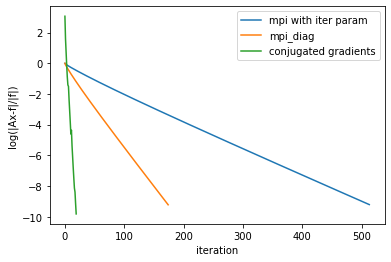

In [153]:
# plot errors and solutions

plt.plot(np.log(mpi_errors_array), label='mpi with iter param')
plt.plot(np.log(mpi_diag_errors_array), label='mpi_diag')
plt.plot(np.log(cg_errors_array), label='conjugated gradients')

plt.xlabel('iteration')
plt.ylabel('log(|Ax-f|/|f|)')
plt.legend(loc='upper right')
plt.show()

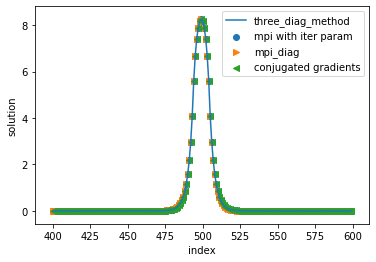

In [159]:
plt.scatter(range(400, 600), x_mpi[400:600], label='mpi with iter param')
plt.scatter(range(400, 600), x_mpi_diag[400:600], label='mpi_diag', marker='>')
plt.scatter(range(400, 600), x_cg[400:600], label='conjugated gradients', marker='<')
plt.plot(range(400, 600), x_check[400:600], label='three_diag_method')

plt.xlabel('index')
plt.ylabel('solution')
plt.legend(loc='upper right')
plt.show()